In [9]:
import random, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial.distance as spsd
sys.path.append(os.path.abspath(os.path.join(r"..", r".")))

from source import const

from matplotlib.patches import Rectangle 

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

In [10]:
%matplotlib notebook
datapath = "../datasets/Table_S2_embryo_data_table.csv"
embryo_data = pd.read_csv(datapath,index_col=False)
embryo_data = embryo_data.loc[embryo_data["inlier"]!=0]


In [11]:
ladpath = "../datasets/external/zygote_paternal_LAD_coordinates.bed"
columns = ["chr","start","end"]
lad_data = pd.read_csv(ladpath, sep='\t', lineterminator='\n', names=columns,index_col=False)

compartment_path = "../datasets/external/PN5_rep1234_paternal_1Mb_compartments.tsv"
columns = ["chr","start","end","gc","eig","comp_ind"]
compartment_data = pd.read_csv(compartment_path, sep='\t', lineterminator='\n', names=columns,index_col=False)

In [12]:

#get all clusters beloning to a particular parent and chromosome
def get_clusters(filtered_cell_idxs, chr_num, cells, parent):
    
    clusters = []
    
    for i in filtered_cell_idxs:
        cell = cells[i]
        chro = cell.loc[cell["chr"] == chr_num]
        cluster = chro.loc[chro["cluster"] == parent]
        clusters.append(cluster)
        
    return clusters


#get vector of compartment eigenvalues for a chromosome
def get_E(chr_num,compartment_data, zygote_signs):

    comp_chr = compartment_data.loc[compartment_data["chr"]=="chr"+str(chr_num)]
    E = np.array([row["eig"] for index, row in comp_chr.iterrows()])
    E = E*zygote_signs[chr_num]
    Ex = np.linspace(0,len(E),len(E)+1)
    
    return(E)

#get lad positions for a chromosome
def get_lads(lad_data, chr_num, B, resolution):

    lad_chr = lad_data.loc[lad_data["chr"]=="chr"+str(chr_num)]
    start = np.array([row["start"] for index, row in lad_chr.iterrows()])
    end = np.array([row["end"] for index, row in lad_chr.iterrows()])
    
    s_inds = np.digitize(start, B*resolution) - 1
    e_inds = np.digitize(end, B*resolution) - 1
    
    return s_inds, e_inds

#get vector of lamin contact probability (i.e. distances below threshold) for a chromosome
def get_T(chr_num, clusters, B, resolution, threshold = 0.5):
    
    lamin_tracks = []
    for i in range(len(B)): lamin_tracks.append([])

    for k in range(len(clusters)):
        cluster = clusters[k]
        P = [row["pos"] for index, row in cluster.iterrows()]
        L = [row["dist_to_lamin"] for index, row in cluster.iterrows()]

        P_inds = np.digitize(P, B*resolution) - 1

        for i in range(len(P_inds)):
            lamin_tracks[P_inds[i]].append(L[i])

    lamin_tracks = np.array(lamin_tracks)
    

    threshold = 0.5
    T = np.zeros(len(B))

    for i in range(len(lamin_tracks)):
        l = np.array(lamin_tracks[i])
        if len(l) == 0: T[i] = np.nan
        else:
            at = len(np.nonzero(l>threshold)[0]) #above threshold
            bt = len(np.nonzero(l<=threshold)[0]) #below threshold            
            #if bt == 0: probs[i] = 0
            #else: 
            T[i] = bt/(bt+at)   
            
                
    T = T - np.nanmean(T)
    
    return T

def do_plot(E, lad_start, lad_end, T, B, resolution):
    
    fig, axs = plt.subplots(3)
    
    hic_ax, lad_ax, spatial_ax = 0, 1, 2

    axs[hic_ax].set_xlim(0,len(E)-1)
    axs[lad_ax].set_xlim(0,len(E)-1)
    axs[spatial_ax].set_xlim(0,len(E)-1)

    axs[hic_ax].set_ylim(-0.15,0.15)
    axs[lad_ax].set_ylim(0,1)
    axs[spatial_ax].set_ylim(-0.5,0.5)
    
    axs[hic_ax].set_ylabel('Hi-C Eig')
    axs[lad_ax].set_ylabel('LAD')
    axs[spatial_ax].set_ylabel('Lamin spatial proximity')    
    axs[spatial_ax].set_xlabel("Chr " + str(chr_num) + " Genomic Coordinate [Mb]")
    
    axs[hic_ax].spines['top'].set_visible(False)
    axs[hic_ax].spines['bottom'].set_visible(False)
    axs[hic_ax].spines['right'].set_visible(False)
    axs[lad_ax].spines['top'].set_visible(False)
    axs[lad_ax].spines['bottom'].set_visible(False)
    axs[lad_ax].spines['left'].set_visible(False)
    axs[lad_ax].spines['right'].set_visible(False)    
    axs[spatial_ax].spines['top'].set_visible(False)
    axs[spatial_ax].spines['right'].set_visible(False)
    
    axs[hic_ax].tick_params(axis='x', which='both',bottom=False,labelbottom=False)
    axs[lad_ax].tick_params(axis='x', which='both',bottom=False,labelbottom=False)
    axs[lad_ax].tick_params(axis='y', which='both',left=False,labelleft=False)
    
    Ex = np.arange(0, len(E))
    z = np.zeros(len(E))
    
    
    axs[hic_ax].plot(Ex,E, color='black',linewidth=1,alpha=0.5)
    axs[hic_ax].plot(Ex,z, color='black',linewidth=1)        
    axs[hic_ax].fill_between(Ex,z, E, where= E >=z,interpolate=True,label='B compartment')
    axs[hic_ax].fill_between(Ex,z, E, where= E < z,interpolate=True, label='A compartment')
    
    axs[spatial_ax].plot(B,T,color='black', linewidth=1,alpha=0.5)
    axs[spatial_ax].plot(B,z, color='black',linewidth=1)
    
    axs[spatial_ax].fill_between(B,z, T, where= T > z,interpolate=True,label='lamin proximal')
    axs[spatial_ax].fill_between(B,z, T, where= T < z,interpolate=True, label = 'lamin distal')
    

    for i in range(0,len(e_inds)):
        if i == 0:
            rect = Rectangle(
                xy=(s_inds[i], 0.5),
                width = e_inds[i] - s_inds[i],
                height = 0.2,
                #facecolor = 'black',
                edgecolor = 'black',
                linewidth = 0.5,
                label = 'LAD'
                )
        else:
            rect = Rectangle(
                xy=(s_inds[i], 0.5),
                width = e_inds[i] - s_inds[i],
                height = 0.2,
                #facecolor = 'black',
                edgecolor = 'black',
                linewidth = 0.5,
                )

        axs[lad_ax].add_patch(rect) 
    
    return fig, axs

In [14]:
chr_num = 11
resolution = 1*10**6
chr_size = const.SIZES_MM10[chr_num]
num_bins = int(np.floor(chr_size/resolution)+1)
clusters = []

parent = 2
zygotes = embryo_data.loc[embryo_data["stage"]=="zygote"]

cells = []
cell_indices = zygotes["cell_index"].unique() 

for cell_index in cell_indices:
    cell = embryo_data.loc[embryo_data["cell_index"] == cell_index]
    cell = cell.loc[cell["chr"] < 21]
    cell = cell.loc[cell["cluster"] == parent]
    cells.append(cell)

<IPython.core.display.Javascript object>


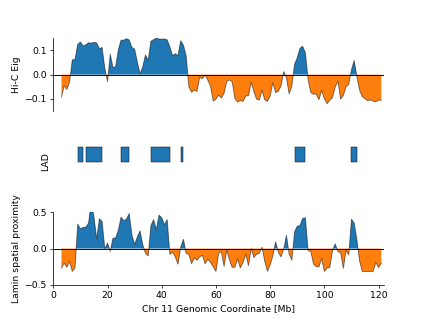

/Users/acp/miniconda2/envs/gwis2/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater_equal
/Users/acp/miniconda2/envs/gwis2/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in less
/Users/acp/miniconda2/envs/gwis2/lib/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in greater
/Users/acp/miniconda2/envs/gwis2/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in less


In [53]:
clusters = []
for i in range(len(cells)):
    cell = cells[i]
    chro = cell.loc[cell["chr"] == 11]
    cluster = chro.loc[chro["cluster"] == 2]
    clusters.append(cluster)
    

E = get_E(chr_num, compartment_data, zygote_signs)

B = np.arange(0, num_bins)
s_inds, e_inds = get_lads(lad_data, chr_num, B, resolution)

B = np.arange(0, num_bins)
T = get_T(chr_num, clusters, B, resolution)

fig, axs = do_plot(E, s_inds, e_inds, T, B, resolution)

plt.savefig("./panel_d_comparison/ab_lad_lamin.svg")